In [15]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from skbio import OrdinationResults
from scipy.stats import pearsonr, spearmanr
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import differential_plot as qq2diffplot
from biom import Table
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex


plt.style.use('ggplot')
%matplotlib inline

def split_taxonomy(taxonomy):
    feat_map = dict(taxonomy.Taxon)
    taxonomy['Taxon'] = [feat_map[feat]
                         if feat in feat_map.keys()
                         else np.nan
                         for feat in taxonomy.index]
    # add taxonomic levels for grouping later (if available)

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxonomy.columns:
            taxonomy_tmp = []
            for tax in taxonomy.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxonomy[lname] = taxonomy_tmp
    return taxonomy

import colorsys
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline


# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12


def differential_plot(diff_df, level, color_by, x_axis, ax,
                      xtitle='log($\\frac{responder}{non-responder}$)',
                      cbartitle='Seeding-Effectiveness',
                      quartile_partition=True,
                      upper=.75, lower=.25, cmap_use='RdBu_r',
                      ntfilter=0, ensure_include = [],
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # make colormap
    # group level
    diff_df_grouped = diff_df.groupby(level).mean()
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_ + ensure_include)]
    elif n_top_bottom_filter:  
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    diff_df[level] = [v_.replace('[','').replace(']','')
                      for v_ in diff_df[level]]
    # ordering
    diff_df_grouped = diff_df.groupby(level).mean()
    order_ = diff_df_grouped[x_axis].sort_values(ascending=False).index
    order_ = {j:i for i, j in enumerate(order_)}
    diff_df['sort'] = [order_[v_] for v_ in diff_df[level]]
    # make a colorbar (first get colors by diffs.)
    all_prop = diff_df.groupby(level).mean().fillna('nan')
    coeff_ = all_prop[color_by].to_dict()
    coeff_[np.nan] = np.nan
    # build the cmap
    # plot
    sns.barplot(y=level,
                x=x_axis,
                palette=cmap_use,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=68)
    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  weight='bold',
                  fontsize=14)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax



In [16]:
# tables
microtbl = q2.Artifact.import_data('FeatureTable[Frequency]', '../data/microbiome-cleaned.biom')
metabtbl = q2.Artifact.import_data('FeatureTable[Frequency]', '../data/metabolite-cleaned.biom')
plasma_metabtbl = q2.Artifact.import_data('FeatureTable[Frequency]', '../data/plasma-metabolite-cleaned.biom')

# metadata
micromf = q2.Metadata(pd.read_csv('../data/microbiome-cleaned.tsv', sep='\t', index_col=0))
metabmf = q2.Metadata(pd.read_csv('../data/metabolite-cleaned.tsv', sep='\t', index_col=0))
plasma_metabmf = q2.Metadata(pd.read_csv('../data/plasma-metabolite-cleaned.tsv', sep='\t', index_col=0))

# metabolite annotations
annot_met = pd.read_csv('../data/Updated_data/annotated_metabolites.txt', sep='\t',index_col=0,dtype=str).fillna('unkown')
annot_met.index = annot_met.index.astype(str)
annot_met[annot_met==''] = np.nan
annot_met = annot_met.replace(r'^\s*$', np.nan, regex=True)
ind_ = set(annot_met.index) & set(metabtbl.view(Table).ids('observation'))
annot_met = annot_met.loc[ind_, :]
annot_met.index.name='featureid'
annot_met.index = annot_met.index.astype(int)

# taxonomy
taxa = q2.Artifact.load('../data/taxonomy.qza')
taxa = taxa.view(q2.Metadata)

# sonbird result imports


# metabolites
path_ = '../results/songbird/songbird-grid/metabolite/'
path_ = os.path.join(path_, 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))-0-3-1.5/differentials.tsv')
metab_diffs = pd.read_csv(path_, sep='\t', index_col=0)
metab_diffs = pd.concat([metab_diffs, annot_met], axis=1, sort=False)
metab_diffs = metab_diffs.dropna(subset=['Compound_Name'])
metab_diffs['compound_clean'] = [v.replace('Spectral Match to ', '').replace(' from NIST14', '').lower().replace(' (10e,12z)','').replace(' (9e,11e)','')
                                      for v in metab_diffs.Compound_Name]
metab_diffs['compound_clean'] = [' '.join(v.split(' ')[1:]) if 'mona' in v.lower() else v
                                      for v in metab_diffs.compound_clean]


# microbes
path_ = '../results/songbird/songbird-grid/microbe'
path_ = os.path.join(path_, 'C(Pain_50_improvement, Treatment("no_response")) * C(timepoint_verbose, Treatment("day-14"))-1-2-0.5/differentials.tsv')
micro_diffs = pd.read_csv(path_, sep='\t', index_col=0)
micro_diffs.index = micro_diffs.index.astype(str)
micro_diffs = pd.concat([micro_diffs, taxa.to_dataframe()], axis=1)
# split the levels into columns
micro_diffs = split_taxonomy(micro_diffs)

# import mmvec Ordination
mmvec_ord = OrdinationResults.read('../results/mmvec/ordination.txt')
metabolite_ord = mmvec_ord.samples
metabolite_ord.columns = 'PC' + (metabolite_ord.columns + 1).astype(str)
metabolite_ord.index = metabolite_ord.index.astype(int)

mmvec_ord_microbe = OrdinationResults.read('../results/mmvec-microbe/ordination.txt')
microbe_ord = mmvec_ord_microbe.samples
#microbe_ord = mmvec_ord.features
microbe_ord.columns = 'PC' + (microbe_ord.columns + 1).astype(str)



# metabolites Plasma
path_ = '../results/songbird/songbird-grid/plasma-metabolite/'
path_ = os.path.join(path_, 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))-2-4-0.5/differentials.tsv')
plasma_metab_diffs = pd.read_csv(path_, sep='\t', index_col=0)
plasma_metab_diffs = pd.concat([plasma_metab_diffs, annot_met], axis=1, sort=False)
plasma_metab_diffs = plasma_metab_diffs.dropna(subset=['Compound_Name'])
plasma_metab_diffs['compound_clean'] = [v.replace('Spectral Match to ', '').replace(' from NIST14', '').lower().replace(' (10e,12z)','').replace(' (9e,11e)','')
                                          for v in plasma_metab_diffs.Compound_Name]
plasma_metab_diffs['compound_clean'] = [' '.join(v.split(' ')[1:]) if 'mona' in v.lower() else v
                                          for v in plasma_metab_diffs.compound_clean]


In [4]:
path_ = '../results/songbird/songbird-grid/plasma-metabolite/'
path_ = os.path.join(path_, 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))-2-4-0.5/differentials.tsv')
plasma_metab_diffs = pd.read_csv(path_, sep='\t', index_col=0)
plasma_metab_diffs = pd.concat([plasma_metab_diffs, annot_met], axis=1, sort=False)


path_ = '../results/songbird/songbird-grid/metabolite/'
path_ = os.path.join(path_, 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))-0-3-1.5/differentials.tsv')
metab_diffs = pd.read_csv(path_, sep='\t', index_col=0)
metab_diffs = pd.concat([metab_diffs, annot_met], axis=1, sort=False)


shared_ = set(plasma_metab_diffs.index) & set(metab_diffs.index)

x = plasma_metab_diffs.reindex(shared_)['C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]'].values
y = metab_diffs.reindex(shared_)['C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]'].values
annot = metab_diffs.reindex(shared_)['Compound_Name']
annot = ['annotated' if isinstance(x, str) else 'unannotated' for x in annot]

corr_df = pd.DataFrame([x, y, annot]).T
corr_df.columns = ['plasma', 'fecal', 'annot']
corr_df = corr_df.dropna(subset=['plasma', 'fecal', 'annot'])


In [5]:
annot_met_out = annot_met.dropna(subset=['Compound_Name'])
annot_met['compound_clean'] = [v.replace('Spectral Match to ', '').replace(' from NIST14', '').lower().replace(' (10e,12z)','').replace(' (9e,11e)','')
                                      for v in annot_met.Compound_Name]
annot_met['compound_clean'] = [' '.join(v.split(' ')[1:]) if 'mona' in v.lower() else v
                                      for v in annot_met.compound_clean]
annot_met.to_csv('../data/annotated_metabolites-cleaned-names.tsv', sep='\t')



In [6]:
q2metab_diffs = metab_diffs[metab_diffs.columns[:4]].dropna(axis=0)
q2metab_diffs.index.name = 'feature-id'
q2metab_diffs.index = q2metab_diffs.index.astype(str)
q2metab_diffs = q2.Artifact.import_data('FeatureData[Differential]', q2metab_diffs)

q2annot_met = metab_diffs[metab_diffs.columns[4:]]
q2annot_met.index = q2annot_met.index.astype(str)
q2annot_met = q2.Metadata(q2annot_met)

metabolomics_qurro = qq2diffplot(q2metab_diffs,
                                       metabtbl,
                                       metabmf,
                                       feature_metadata = q2annot_met)
metabolomics_qurro.visualization.save('../results/songbird/metabolite-qurro.qzv')



'../results/songbird/metabolite-qurro.qzv'

In [7]:
q2plasma_metab_diffs = plasma_metab_diffs[plasma_metab_diffs.columns[:4]].dropna(axis=0)
q2plasma_metab_diffs.index.name = 'feature-id'
q2plasma_metab_diffs.index = q2plasma_metab_diffs.index.astype(str)
q2plasma_metab_diffs = q2.Artifact.import_data('FeatureData[Differential]', q2plasma_metab_diffs)

q2plasma_annot_met = plasma_metab_diffs[plasma_metab_diffs.columns[4:]]
q2plasma_annot_met.index = q2plasma_annot_met.index.astype(str)
q2plasma_annot_met = q2.Metadata(q2plasma_annot_met)

metabolomics_qurro = qq2diffplot(q2plasma_metab_diffs,
                                       plasma_metabtbl,
                                       plasma_metabmf,
                                       feature_metadata = q2plasma_annot_met)
metabolomics_qurro.visualization.save('../results/songbird/plasma-metabolite-qurro.qzv')


316 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.


'../results/songbird/plasma-metabolite-qurro.qzv'

In [8]:
q2micro_diffs = micro_diffs[micro_diffs.columns[:4]].dropna(axis=0)
q2micro_diffs.index.name = 'feature-id'
q2micro_diffs = q2.Artifact.import_data('FeatureData[Differential]', q2micro_diffs)

microbiome_qurro = qq2diffplot(q2micro_diffs,
                                     microtbl,
                                     micromf,
                                     feature_metadata = taxa)
microbiome_qurro.visualization.save('../results/songbird/microbe-qurro.qzv')


'../results/songbird/microbe-qurro.qzv'

# metabolites

In [17]:

bile_use = pd.read_csv('../data/bileacids_key.txt', sep='\t')
bile_use = bile_use.dropna(subset=['metabolomics_name'])
bile_use['metabolomics_name_lower'] = [str(x).lower() for x in bile_use.metabolomics_name]
bile_use = bile_use.groupby('metabolomics_name_lower').agg('first')
locate_bile = [pd.DataFrame([(j.lower(), ind, i, bile_use.index[i]) for i, s in enumerate(bile_use.index)
                             if j.lower() == s])
               for ind, j in zip(metab_diffs.index ,metab_diffs['Compound_Name'])
               if j.lower() in bile_use.index]
locate_bile = pd.concat(locate_bile).reset_index(drop=True)
locate_bile.columns = ['Compound_Name','index_metab','index_bile', 'matched_name']
add_info = pd.DataFrame([bile_use.iloc[ind_bile, :].values for ind_bile in locate_bile['index_bile']])
locate_bile = pd.concat([locate_bile, add_info], axis=1)
locate_bile_agg = locate_bile.groupby(2).agg({'index_metab':list, 2:list, 3:list, 4:list, 5:list})


metab_diffs['bilename'] = np.nan
metab_diffs['abbrev'] = np.nan
metab_diffs['bile_ps'] = np.nan
metab_diffs['bile_conj'] = np.nan

tmp_dict = locate_bile_agg.to_dict()

for name_, indicies in tmp_dict['index_metab'].items():
    for j_, ind_ in enumerate(indicies):
        metab_diffs.loc[ind_, 'compound_clean'] = name_
        metab_diffs.loc[ind_, 'bilename'] = tmp_dict[2][name_][j_]
        metab_diffs.loc[ind_, 'abbrev'] = tmp_dict[3][name_][j_]
        metab_diffs.loc[ind_, 'bile_ps'] = tmp_dict[4][name_][j_]
        metab_diffs.loc[ind_, 'bile_conj'] = tmp_dict[5][name_][j_]

metab_diffs.head(5)



,Intercept,"C(ATTRIBUTE_Pain_50, Treatment(""no_response""))[T.response]","C(ATTRIBUTE_Time, Treatment(""day-14""))[T.day+14]","C(ATTRIBUTE_Pain_50, Treatment(""no_response""))[T.response]:C(ATTRIBUTE_Time, Treatment(""day-14""))[T.day+14]",Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,...,SpectrumID,TIC_Query,UpdateWorkflowName,tags,Unnamed: 36,compound_clean,bilename,abbrev,bile_ps,bile_conj
featureid,,,,,,,,,,,,,,,,,,,,,
3,1.726852,0.928864,0.770937,1.324320,M+H,unkown,1,sphingosin C16 (Artifact)-emf,Crude,unkown,...,CCMSLIB00005463721,391600,UPDATE-SINGLE-ANNOTATED-BRONZE,NaN,unkown,sphingosin c16 (artifact)-emf,NaN,NaN,NaN,NaN
9,0.427709,1.080898,1.284578,0.644998,M+H,547-75-1,1,hyocholic acid,commercial,A. Jarmusch,...,CCMSLIB00005435541,456100,UPDATE-SINGLE-ANNOTATED-GOLD,NaN,unkown,hyocholic acid,NaN,NaN,NaN,NaN
10,-1.013820,-0.170734,-0.206976,0.122880,M+H,84742,1,Spectral Match to Dibutyl phthalate from NIST14,Isolated,Data deposited by lfnothias,...,CCMSLIB00003138727,41300,UPDATE-SINGLE-ANNOTATED-BRONZE,NaN,unkown,dibutyl phthalate,NaN,NaN,NaN,NaN
17,0.469199,0.806473,0.363002,1.309115,M+H,629549,1,Spectral Match to Palmitamide from NIST14,Isolated,Data deposited by lfnothias,...,CCMSLIB00003135927,348400,UPDATE-SINGLE-ANNOTATED-BRONZE,NaN,unkown,palmitamide,NaN,NaN,NaN,NaN
24,0.020008,0.731024,0.841907,1.356392,M+H,112845,1,"Spectral Match to 13-Docosenamide, (Z)- from N...",Isolated,Data deposited by fevargas,...,CCMSLIB00003138796,91500,UPDATE-SINGLE-ANNOTATED-BRONZE,NaN,unkown,"13-docosenamide, (z)-",NaN,NaN,NaN,NaN


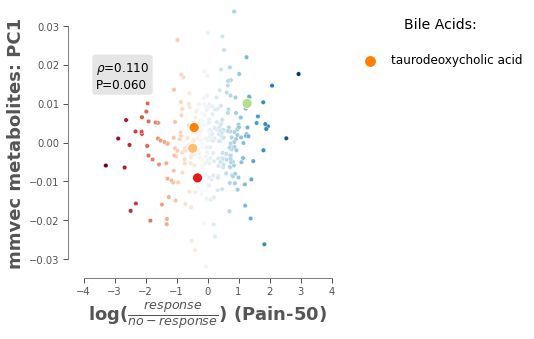

In [18]:
x_ = 'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]'
#x_ = 'C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]'
#x_ = 'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]:C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]'
y_ = 'PC1'

metab_comparedf = pd.concat([metab_diffs, metabolite_ord], axis=1, sort=True).dropna(subset=['PC1', x_])
metab_comparedf.columns = metab_comparedf.columns.astype(str)


metab_filt = metabtbl.view(Table)
metab_filt_ = metab_filt.matrix_data.toarray()
keep_ = set(metab_comparedf.index.astype(str)) & set(metab_filt.ids('observation')[(metab_filt_.astype(bool).sum(1) / metab_filt_.shape[1]) > 0.0])
keep_ = list(map(int, keep_))
metab_comparedf = metab_comparedf.reindex(keep_)

metab_comparedf_cleaned = metab_comparedf.drop([3175, 1405, 797, 1063, 1864, 1875])
metab_comparedf_agg = metab_comparedf_cleaned.groupby('compound_clean').agg({'PC1':'mean',
                                                                             'PC2':'mean',
                                                                             'PC3':'mean',
                                                                              x_:'mean',
                                                                             'Data_Collector':'first',
                                                                             'bilename':'first',
                                                                             'bile_ps':'first'})
#metab_comparedf_agg = metab_comparedf.copy()

y = metab_comparedf_agg.loc[:, ['PC1','PC2','PC3']].values * - 1
y = y - y.mean(axis=0)
y = y - y.mean(axis=1).reshape(-1, 1)
metab_comparedf_agg.loc[:, ['PC1','PC2','PC3']] = y
metab_comparedf_agg[x_] -= metab_comparedf_agg[x_].mean()

#metab_comparedf_agg = metab_comparedf_agg[~metab_comparedf_agg.bilename.isin(['12-ketodeoxycholic acid'])]

# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 10 
plt.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(1,1, figsize=(5,5))

rho_, p_ = spearmanr(metab_comparedf_agg[x_], metab_comparedf_agg[y_])

"""p_ = str(p_)
p_ = '$\\mathit{' + p_[:4] + 'x 10^{' + p_.split('e')[-1].replace('0','') + '}}$' 
props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(0.1, 0.7, "$\\rho$=%.3f\nP=%s" % (rho_, p_),
        transform=ax.transAxes, bbox=props, fontsize=12)"""

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(0.1, 0.7, "$\\rho$=%.3f\nP=%.3f" % (rho_, p_),
        transform=ax.transAxes, bbox=props, fontsize=12)

sns.scatterplot(x=x_, y=y_, hue=metab_comparedf_agg[x_],
                palette='RdBu', data=metab_comparedf_agg,
                s=20, ax=ax)
"""sns.regplot(x=x_, y=y_, color='black', data=metab_comparedf_agg,
            scatter_kws={"s": 0},
            ci=100, ax=ax, order=1)"""

#cmap_keys = set(metab_comparedf_agg.bilename.dropna())
"""metab_color_map = {'taurocholic acid':'#fdbf6f',
                   'taurodeoxycholic acid':'#ff7f00',
                   'taurochenodeoxycholic acid':'#1f78b4',
                   'dehydrocholic acid':'#fb9a99',
                   'cholic acid':'#e31a1c',
                   '6-hydroxycholic acid':'#a6cee3',}"""

metab_color_map = {'taurocholic acid':'#fdbf6f',
                   'taurodeoxycholic acid':'#ff7f00',
                   'deoxycholic acid':'#b2df8a',
                   'cholic acid':'#e31a1c'}

#add_colors_keys = cmap_keys - set(metab_color_map.keys())
#print(add_colors_keys)
#add_colors = [to_hex(x) for x in list(cm.tab20(np.linspace(0, 1, 20)))]
#add_colors = list(set(add_colors) - set(metab_color_map.values()))
#cmap_new = {cmap_keys:c for cmap_keys, c in zip(add_colors_keys, add_colors)}
#cmap_new = {**cmap_new, **metab_color_map}
metab_comparedf_agg_ = metab_comparedf_agg[metab_comparedf_agg.bilename.isin(metab_color_map.keys())]

cmap_new = metab_color_map
sns.scatterplot(x=x_, y=y_,
                hue='bilename',
                palette=cmap_new,
                alpha=1,
                data=metab_comparedf_agg_,
                s=100, ax=ax)

#ax.legend_.remove()
ax.set_xlabel("log($\\frac{response}{no-response}$) (Pain-50)", weight='bold', fontsize=18)
ax.set_ylabel("mmvec metabolites: PC1", weight='bold', fontsize=18)
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[7:], labels[7:], loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':12},
                           title="Bile Acids:\n",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
ax.set_ylim(-0.035, 0.035)
ax.spines['left'].set_bounds(-0.03, 0.03)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
    
plt.savefig('../results/tables-figures/figures/mmvec-regplot-metabolites.pdf',
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


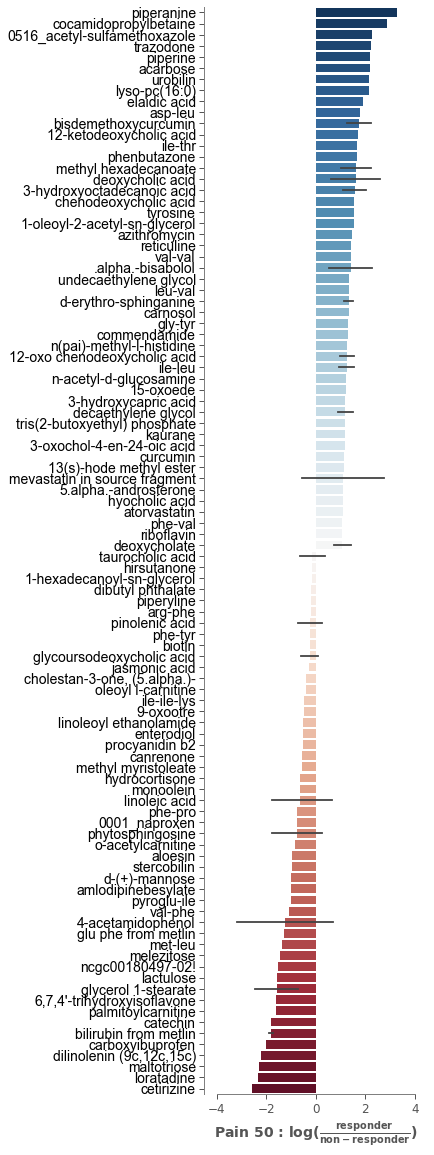

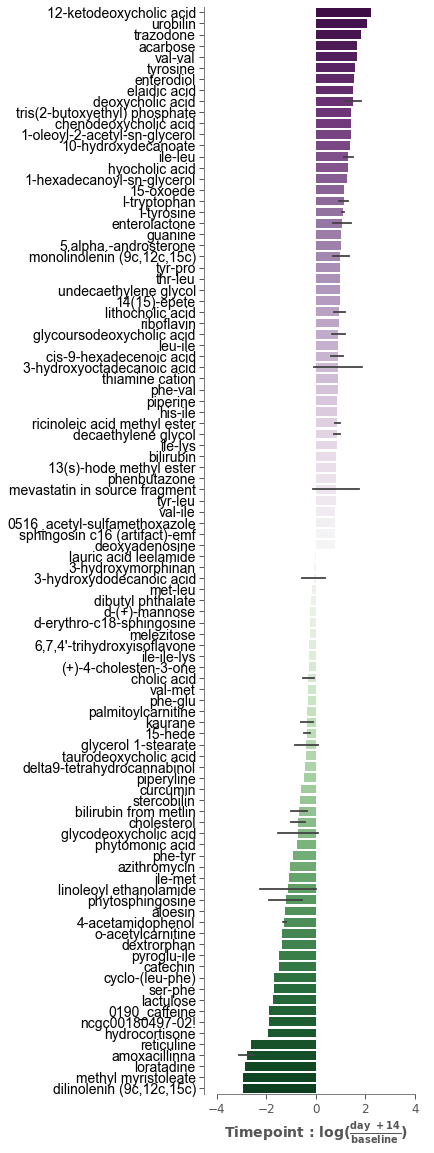

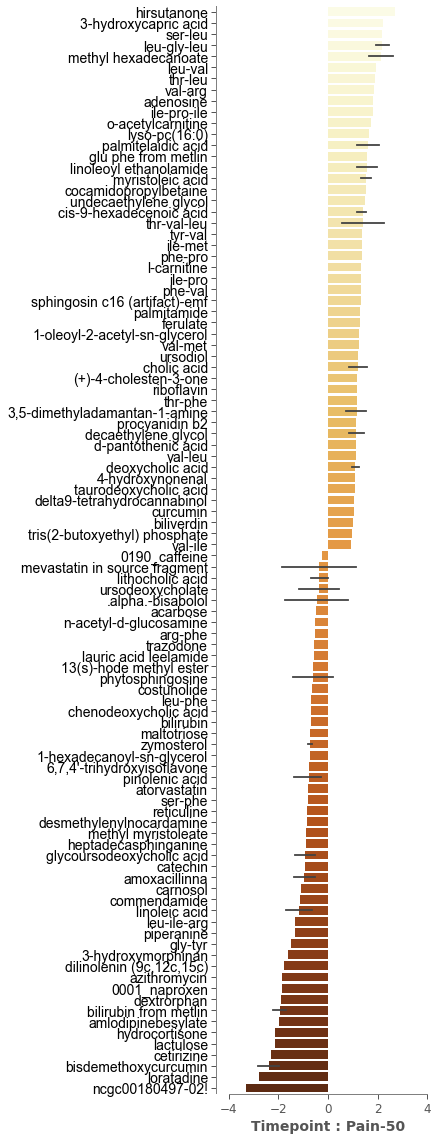

In [20]:

# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12

fig, ax = plt.subplots(1,1, figsize=(4,20))

plot_metab_diffs_cleaned = metab_comparedf_cleaned.copy()
plot_metab_diffs_cleaned['compound_clean'] = [v if len(v) < 30 else np.nan
                                      for v in plot_metab_diffs_cleaned.compound_clean]
plot_metab_diffs_cleaned = plot_metab_diffs_cleaned.dropna(subset=['compound_clean'])
plot_metab_diffs_cleaned = plot_metab_diffs_cleaned[~plot_metab_diffs_cleaned['compound_clean'].isin(['1'])]

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]',
                   ax, upper=.75, lower=.25, ntfilter=0,
                  #ensure_include=['conjugated linoleic acid'],
                   xtitle='Pain 50 : log($\\frac{\\mathbf{responder}}{\\mathbf{non-responder}}$)')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
   


plt.savefig('../results/tables-figures/figures/pain-interaction-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                  'C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                   ax, upper=.75, lower=.25, ntfilter=0,cmap_use='PRGn',
                   #ensure_include=['conjugated linoleic acid'],
                   xtitle='Timepoint : log($\\frac{\\mathbf{day\,\,+14}}{\\mathbf{baseline}}$)')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
   


plt.savefig('../results/tables-figures/figures/time-interaction-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]:C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]:C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                   ax, upper=.75, lower=.25, ntfilter=0,cmap_use='YlOrBr',
                   #ensure_include=['conjugated linoleic acid'],
                   xtitle='Timepoint : Pain-50')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
   

plt.savefig('../results/tables-figures/figures/time-pain-interaction-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


# plasma

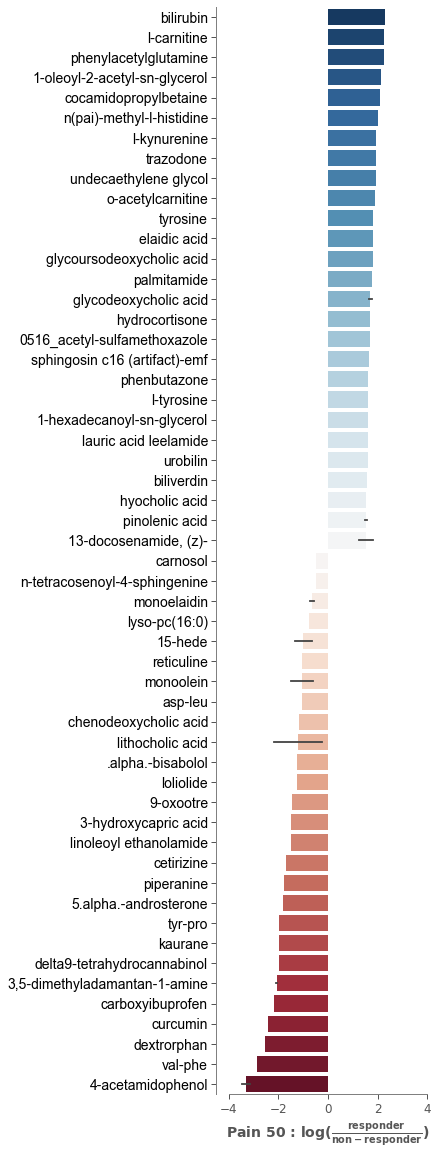

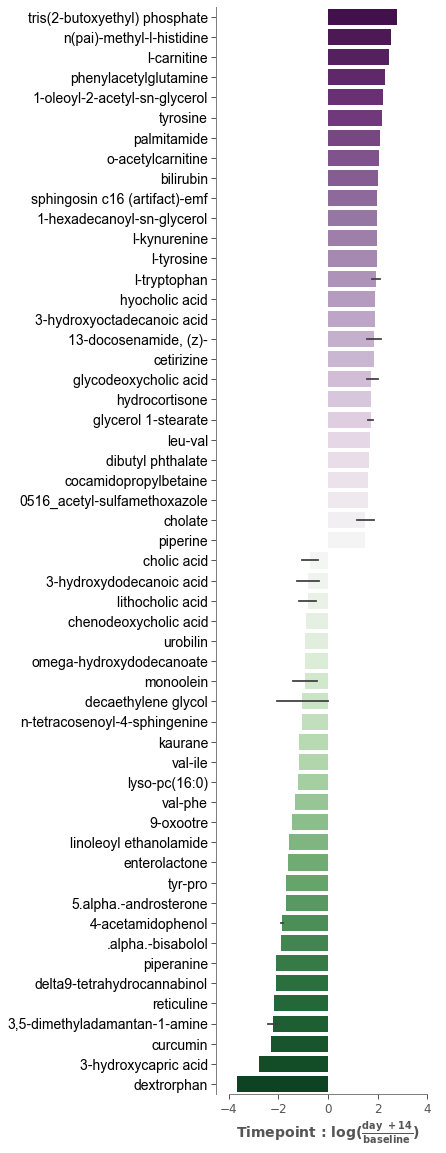

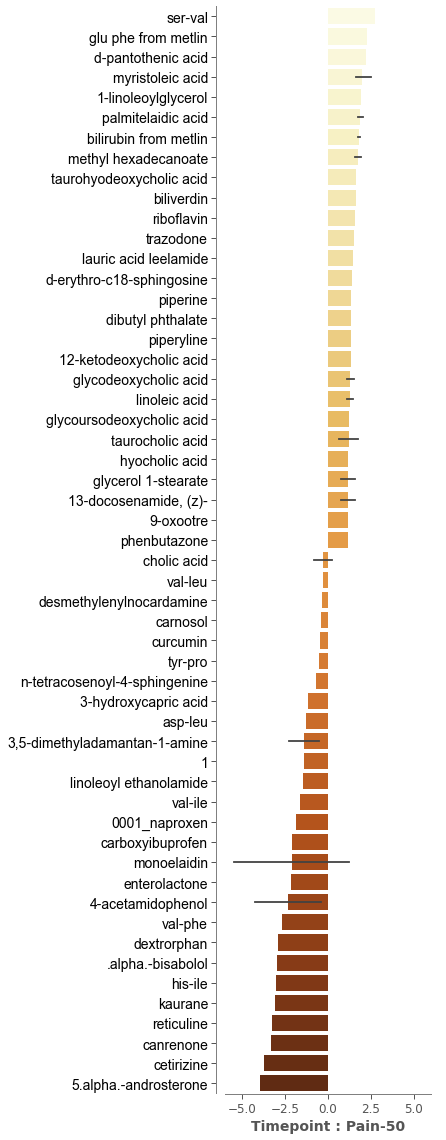

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,20))

plot_metab_diffs_cleaned = plasma_metab_diffs.copy().dropna(subset=['C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]'])
plot_metab_diffs_cleaned['compound_clean'] = [v if len(v) < 30 else np.nan
                                      for v in plot_metab_diffs_cleaned.compound_clean]
plot_metab_diffs_cleaned = plot_metab_diffs_cleaned.dropna(subset=['compound_clean'])

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]',
                   ax, upper=.75, lower=.25, ntfilter=0,
                   xtitle='Pain 50 : log($\\frac{\\mathbf{responder}}{\\mathbf{non-responder}}$)')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
   
plt.savefig('../results/tables-figures/figures/pain-interaction-plasma-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                  'C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                   ax, upper=.75, lower=.25, ntfilter=0,cmap_use='PRGn',
                   xtitle='Timepoint : log($\\frac{\\mathbf{day\,\,+14}}{\\mathbf{baseline}}$)')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)
   


plt.savefig('../results/tables-figures/figures/time-interaction-plasma-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(plot_metab_diffs_cleaned, 'compound_clean',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]:C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                  'C(ATTRIBUTE_Pain_50, Treatment("no_response"))[T.response]:C(ATTRIBUTE_Time, Treatment("day-14"))[T.day+14]',
                   ax, upper=.75, lower=.25, ntfilter=0,cmap_use='YlOrBr',
                   xtitle='Timepoint : Pain-50')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-6.5, 6.5)
ax.spines['bottom'].set_bounds(-6, 6)
   

plt.savefig('../results/tables-figures/figures/time-pain-interaction-plasma-met-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()

# microbes

SpearmanrResult(correlation=0.19969005225139574, pvalue=1.579590324223656e-31)


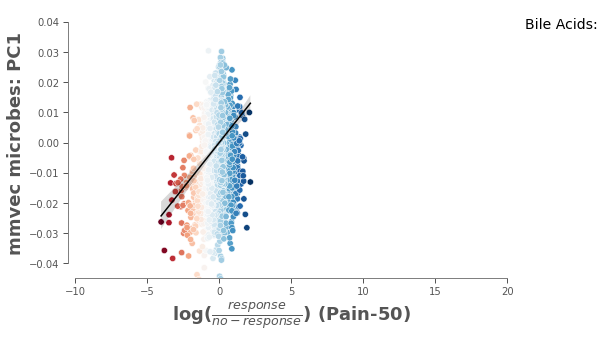

In [22]:
x_ = 'C(Pain_50_improvement, Treatment("no_response"))[T.response]'
#x_ = 'C(timepoint_verbose, Treatment("day-14"))[T.day+14]'
x_ = 'C(Pain_50_improvement, Treatment("no_response"))[T.response]:C(timepoint_verbose, Treatment("day-14"))[T.day+14]'
y_ = 'PC1'

micro_comparedf = pd.concat([microbe_ord, micro_diffs], axis=1, sort=True).dropna(subset=[x_])

micro_filt = microtbl.view(Table)
micro_filt_ = micro_filt.matrix_data.toarray()
keep_ = set(micro_comparedf.index) & set(micro_filt.ids('observation')[(micro_filt_.astype(bool).sum(1) / micro_filt_.shape[1]) > 0.0])

micro_comparedf = micro_comparedf.reindex(keep_)
y = micro_comparedf.loc[:, ['PC1','PC2','PC3']].values
y = y - y.mean(axis=0)
y = y - y.mean(axis=1).reshape(-1, 1)
micro_comparedf.loc[:, ['PC1','PC2','PC3']] = y


# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 10 
plt.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(1,1, figsize=(8,5))

print(spearmanr(micro_comparedf[x_], micro_comparedf[y_]))

sns.scatterplot(x=x_, y=y_, hue=micro_comparedf[x_], palette='RdBu', data=micro_comparedf,
                s=40, ax=ax)
sns.regplot(x=x_, y=y_, color='black', data=micro_comparedf,
            scatter_kws={"s": 0},
            ci=100, ax=ax, order=1)


#ax.legend_.remove()
ax.set_xlabel("log($\\frac{response}{no-response}$) (Pain-50)", weight='bold', fontsize=18)
ax.set_ylabel("mmvec microbes: PC1", weight='bold', fontsize=18)
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[7:], labels[7:], loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':12},
                           title="Bile Acids:\n",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)

ax.set_ylim(-0.045, 0.045)
ax.spines['left'].set_bounds(-.04, .04)
ax.set_xlim(-10.5, 20.5)
ax.spines['bottom'].set_bounds(-10, 20)

        
"""plt.savefig('../results/tables-figures/figures/mmvec-regplot-microbes.pdf',
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""


plt.show()

{'Anaerostipes', 'Bacteroides', 'Faecalibacterium', 'Actinomyces', 'Phascolarctobacterium', 'Acidaminococcus', 'Prevotella', 'WAL_1855D', 'Holdemania', 'Dialister', 'Collinsella', 'Gemmiger'}


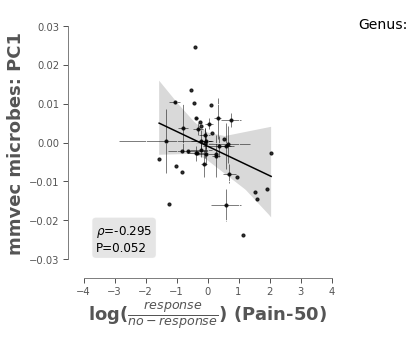

In [23]:
#x_ = 'C(Pain_50_improvement, Treatment("no_response"))[T.response]'
x_ = 'C(timepoint_verbose, Treatment("day-14"))[T.day+14]'
#x_ = 'C(Pain_50_improvement, Treatment("no_response"))[T.response]:C(timepoint_verbose, Treatment("day-14"))[T.day+14]'
y_ = 'PC1'

micro_comparedf = pd.concat([microbe_ord, micro_diffs], axis=1, sort=True).dropna(subset=[x_])
gcount = micro_comparedf.genus.value_counts()
micro_comparedf = micro_comparedf[micro_comparedf.genus.isin(list(gcount[gcount > 1].index))]

micro_filt = microtbl.view(Table)
micro_filt_ = micro_filt.matrix_data.toarray()
keep_ = set(micro_comparedf.index) & set(micro_filt.ids('observation')[(micro_filt_.astype(bool).sum(1) / micro_filt_.shape[1]) > 0.25])

micro_comparedf = micro_comparedf.reindex(keep_)


y = micro_comparedf.loc[:, ['PC1','PC2','PC3']].values
y = y - y.mean(axis=0)
y = y - y.mean(axis=1).reshape(-1, 1)
micro_comparedf.loc[:, ['PC1','PC2','PC3']] = y

level_ = 'genus'
micro_comparedf[micro_comparedf.columns[3:7]] -= micro_comparedf[micro_comparedf.columns[3:7]].mean(0)
micro_comparedf_std = micro_comparedf.dropna(subset=[level_]).groupby(level_).sem()
micro_comparedf = micro_comparedf.dropna(subset=[level_]).groupby(level_).mean()

# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 10 
plt.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(1,1, figsize=(5,5))

rho_, p_ = spearmanr(micro_comparedf[x_], micro_comparedf[y_])
props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(0.1, 0.1, "$\\rho$=%.3f\nP=%.3f" % (rho_, p_),
        transform=ax.transAxes, bbox=props, fontsize=12)
ax.errorbar(micro_comparedf[x_], micro_comparedf[y_],
            xerr=micro_comparedf_std[x_],
            yerr=micro_comparedf_std[y_],
            fmt="o", color='black',lw=1,zorder=-1,
            markersize=0, alpha=0.5)

sns.regplot(x=x_, y=y_, color='black', data=micro_comparedf,
            scatter_kws={"s": 10},
            ci=100, ax=ax, order=1)

micro_comparedf_ = micro_comparedf.loc[((micro_comparedf[x_] > 0.5) & (micro_comparedf[y_] < 0) ) | (micro_comparedf[x_] < -1), :]


cmap_keys = set(micro_comparedf_.index.dropna())
micro_color_map = {'Akkermansia':'#33a02c',
                   'Bifidobacterium':'#cab2d6',
                   'Bilophila':'#6a3d9a'}
add_colors_keys = cmap_keys - set(micro_color_map.keys())
print(add_colors_keys)
add_colors = [to_hex(x) for x in list(cm.tab20(np.linspace(0, 1, 20)))]
add_colors = list(set(add_colors) - set(micro_color_map.values()))
cmap_new = {cmap_keys:c for cmap_keys, c in zip(add_colors_keys, add_colors)}
cmap_new = {**cmap_new, **micro_color_map}

"""sns.scatterplot(x=x_, y=y_, hue=micro_comparedf_.index, palette=cmap_new, data=micro_comparedf_,
                s=50, ax=ax)"""


#ax.legend_.remove()
ax.set_xlabel("log($\\frac{response}{no-response}$) (Pain-50)", weight='bold', fontsize=18)
ax.set_ylabel("mmvec microbes: PC1", weight='bold', fontsize=18)
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':12},
                           title="Genus:\n",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)

ax.set_ylim(-0.035, 0.035)
ax.spines['left'].set_bounds(-.03, .03)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)

        
"""plt.savefig('../results/tables-figures/figures/mmvec-regplot-microbes.pdf',
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""


plt.show()


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


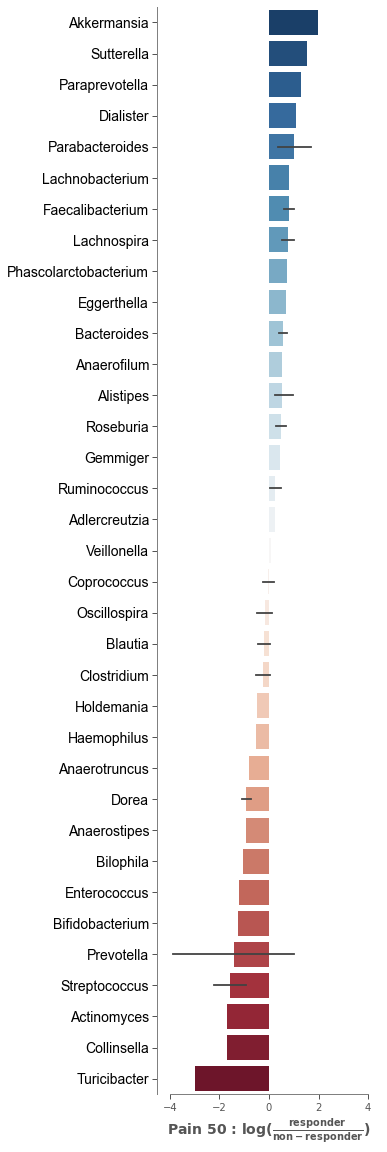

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


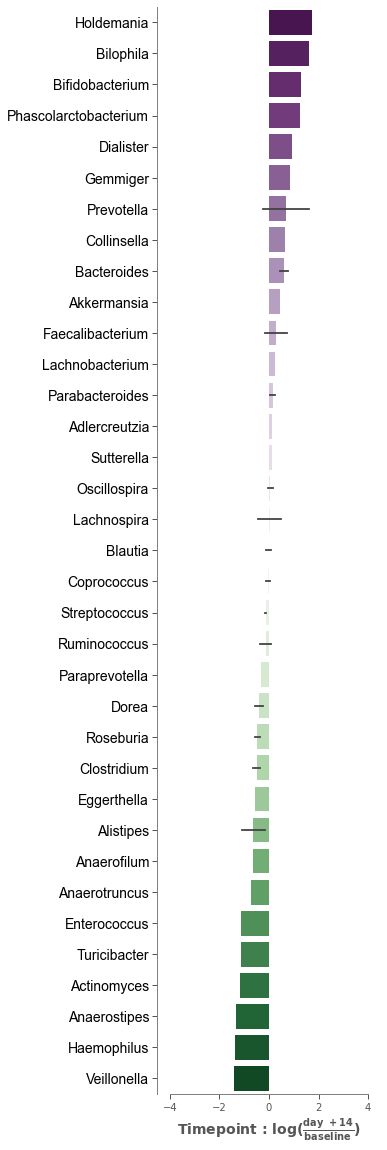

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


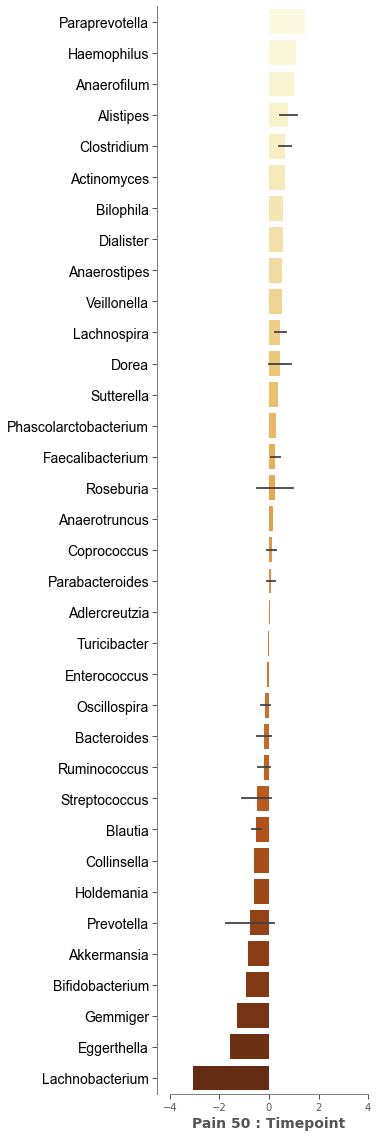

In [24]:

micro_comparedf = pd.concat([microbe_ord, micro_diffs], axis=1, sort=True)

micro_filt = microtbl.view(Table)
micro_filt_ = micro_filt.matrix_data.toarray()
keep_ = set(micro_comparedf.index) & set(micro_filt.ids('observation')[(micro_filt_.astype(bool).sum(1) / micro_filt_.shape[1]) > 0.5])

micro_comparedf = micro_comparedf.reindex(keep_)

micro_comparedf[micro_comparedf.columns[3:7]] -= micro_comparedf[micro_comparedf.columns[3:7]].mean(0)

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(micro_comparedf, 'genus',
                  'C(Pain_50_improvement, Treatment("no_response"))[T.response]',
                 'C(Pain_50_improvement, Treatment("no_response"))[T.response]',
                  ax, quartile_partition=False, ntfilter=0,upper=.75, lower=.25, 
                  xtitle='Pain 50 : log($\\frac{\\mathbf{responder}}{\\mathbf{non-responder}}$)',)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)


plt.savefig('../results/tables-figures/figures/pain-micro-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(micro_comparedf, 'genus',
                  'C(timepoint_verbose, Treatment("day-14"))[T.day+14]',
                 'C(timepoint_verbose, Treatment("day-14"))[T.day+14]',
                  ax, quartile_partition=False, ntfilter=0,cmap_use='PRGn',
                  upper=.75, lower=.25, 
                  xtitle='Timepoint : log($\\frac{\\mathbf{day\,\,+14}}{\\mathbf{baseline}}$)',)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)


plt.savefig('../results/tables-figures/figures/time-micro-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


fig, ax = plt.subplots(1,1, figsize=(4,20))

differential_plot(micro_comparedf, 'genus',
                  'C(Pain_50_improvement, Treatment("no_response"))[T.response]:C(timepoint_verbose, Treatment("day-14"))[T.day+14]',
                 'C(Pain_50_improvement, Treatment("no_response"))[T.response]:C(timepoint_verbose, Treatment("day-14"))[T.day+14]',
                  ax, quartile_partition=False, ntfilter=0,cmap_use='YlOrBr',
                  upper=.75, lower=.25, 
                  xtitle='Pain 50 : Timepoint',)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_xlim(-4.5, 4.5)
ax.spines['bottom'].set_bounds(-4, 4)


plt.savefig('../results/tables-figures/figures/time-pain-interaction-micro-diffs.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()



# conditional probs


In [25]:
conditional_probs = pd.read_csv('../results/mmvec/ranks.tsv', sep='\t', index_col=0)
conditional_probs.head(2)


,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,TACGGAAGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGCTTTTAAGTCAGCGGTCAAATGTCGTGGCTCAACCATGTCAAGCCGTTGAAACTGTAAGCCTTGAGTCTGCACAGGGCACATGGAATTCGTGGT,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGACGGGTTTTTAAGTCAGCTGTGAAAGTTTGGGGCTCAACCTTAAAATTGCAGTTGAAACTGGAGACCTTGAGTACGGTTGAGGCAGGCGGAATTCGTGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTCGTACTTGAGTATCGGAGAGGTAAGTGGAATTCCTAG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCGGAATTCGTGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGCGACCTTGAGTGCAACAGAGGTAGGCGGAATTCGTGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGG,TACGGAAGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGCTTTTAAGTCAGCGGTCAAATGTCACGGCTCAACCGTGGCCAGCCGTTGAAACTGCAAGCCTTGAGTCTGCACAGGGCACATGGAATTCGTGGT,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGTGTAGGTGGCATCACAAGTCAGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTGCTTTTGAAACTGTGGAGCTGGAGTGCAGGAGAGGCAAGTGGAATTCCTAG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTTTTAAGTCAGCGGTGAAAGTCTGTGGCTCAACCATAGAATTGCCGTTGAAACTGGGGGGCTTGAGTATGTTTGAGGCAGGCGGAATGCGTGG,...,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGCGTAGGCGGGATGGCAAGTCAGATGTGAAATCCATGGGCTCAACCCATGAACTGCATTTGAAACTGTCGTTCTTGAGTATCGGAGAGGCAAGCGGAATTCCTAG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAACAGCAAGTCTGATGTGAAAACCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTTGATCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCGGTTTCGTAAGTCGTGTGTGAAAGGCGGGGGCTCAACCCCCGGACTGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG,TACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGGGTGCGCAGACGGTTTATTAAGTCTAAAATCAAATCTTGGGGCTCAACCCCATTCCGTTTTAGAAACTGGTAGACTTGAGTATGGTAGAGGCAAATGGAATTCCTAGT,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGTGTGCAAGTCAGATGTGAAATCTGGAGGCTCAACCTCCAAACTGCATTTGAAACTGTGCATCTTGAGTATCGGAGAGGTAATCGGAATTCCTTG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGTATGGCAAGTCAGAGGTGAAAACCCAGGGCTTAACCTTGGGATTGCCTTTGAAACTGTCAGACTAGAGTGCAGGAGGGGTAAGTGGAATTCCTAG,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGAGGGCAAGTCAGATGTGAAATCCACGGGCTCAACTCGTGAACTGCATTTGAAACTACTCTTCTTGAGTATCGGAGAGGCAATCGGAATTCCTAG,TACGTAGGGGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTGTGTAGGCGGTTTATTAAGTCCGAGATGAAAGGCTATGGCTTAACCATAGTTTGTTTCGGAAACTGGTAGACTAGAGTGCAGTAGAGGCAAATGGAATTCATAGT,TACGTAGGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGATGGCAAGTCAGATGTGAAAACTATGGGCTCAACCCATAGCCTGCATTTGAAACTGTCGTTCTTGAGTGATGGAGAGGCAAGCGGAATTCCGTG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGAAGCAAGTCTGAAGTGAAAGGTTGGGGCTCAACCCCGAAACTGCTTTGGAAACTGTTTAACTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG
featureid,,,,,,,,,,,,,,,,,,,,,
1,0.568429,1.157176,0.050239,1.025377,0.854079,0.823405,1.092064,-0.297447,1.063710,1.396339,...,-0.219615,0.696856,-0.519396,-0.096331,0.906439,1.343393,0.830166,0.683677,-0.098732,0.139767
2,1.244447,1.483781,0.461708,1.710644,1.506846,1.712189,-0.187497,1.451723,0.439557,0.342668,...,0.491045,1.414012,0.774504,0.786282,1.246649,0.596191,1.525960,1.712278,1.415405,2.398220


In [26]:
"""use_metab = metab_comparedf[metab_comparedf.bilename.isin(['taurocholic acid',
                                                           'taurodeoxycholic acid',
                                                           'taurochenodeoxycholic acid',
                                                           'deoxycholic acid',
                                                           'cholic acid',
                                                           '6-hydroxycholic acid'])].index"""
use_microbe = micro_diffs[micro_diffs.genus.isin(['Akkermansia','Bifidobacterium','Bilophila'])].index
use_metab  = [821,5755,338,1405,1875,797,1063]

mmvec_conditionals = conditional_probs.loc[use_metab, use_microbe].dropna(axis=1)
mmvec_conditionals = mmvec_conditionals[set(mmvec_conditionals.columns) & set(micro_comparedf.index)]
mmvec_conditionals.head(2)


,TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGG,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG,TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGCTTGGTAAGTCAGGGGTGAAATCCCACAGCCCAACTGTGGAACTGCCTTTGATACTGCCAGGCTTGAGTACCGGAGAGGGTGGCGGAATTCCAGG
featureid,,,
821,2.732077,2.026022,3.490568
5755,-0.052573,-0.838834,0.990332


In [27]:
mmvec_conditionals['ps'] = [metab_comparedf.loc[int(x), 'bilename'].replace('_','').lstrip().rstrip()
                            for x in mmvec_conditionals.index]
"""metab_color_map = {'taurocholic acid':'#fdbf6f',
                   'taurodeoxycholic acid':'#ff7f00',
                   'deoxycholic acid':'#b2df8a',
                   'cholic acid':'#e31a1c'}"""
metab_color_map = {'taurocholic acid':'#fdbf6f',
                   'taurodeoxycholic acid':'#ff7f00',
                   'deoxycholic acid':'#b2df8a',
                   'cholic acid':'#e31a1c'}

metabclass = mmvec_conditionals.pop("ps")
row_colors = metabclass.map(metab_color_map)

mmvec_conditionals.loc['sp', :] = [micro_comparedf.loc[str(i), 'genus'].replace('_','').lstrip().rstrip()
                                   for i in mmvec_conditionals.columns]
taxonclass = mmvec_conditionals.T.pop('sp').dropna()

micro_color_map = {'Akkermansia':'#33a02c',
                   'Bifidobacterium':'#cab2d6',
                   'Bilophila':'#6a3d9a'}

col_colors = taxonclass.map(micro_color_map)

mmvec_conditionals = mmvec_conditionals.drop('sp')
mmvec_conditionals = mmvec_conditionals.astype(float)

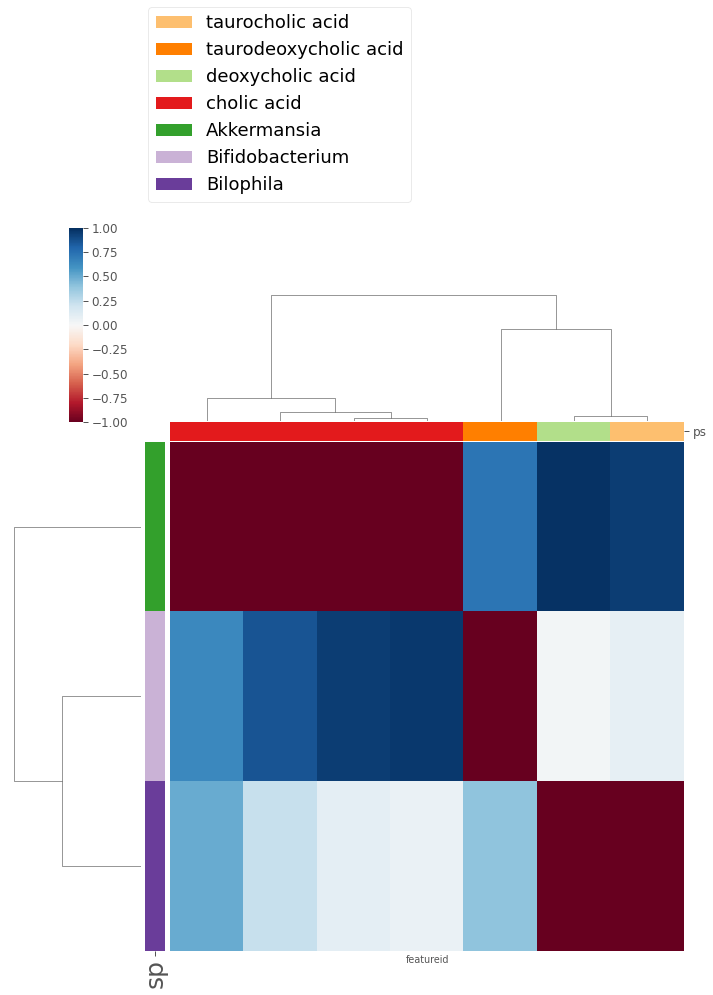

In [28]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 25 
plt.rcParams['ytick.labelsize'] = 12

g = sns.clustermap(mmvec_conditionals.T * -1,
                   vmax=1.0,
                   vmin=-1.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=row_colors,
                   row_colors=col_colors,
                   yticklabels=False,
                   xticklabels=False,
                   cmap="RdBu",
                   z_score=1)


legend_ = {**metab_color_map, **micro_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
legend = g.ax_col_dendrogram.legend(loc=2, 
                         bbox_to_anchor=(-0.06, 3.2),
                         prop={'size':18},
                         fancybox=True, framealpha=0.5, 
                         ncol=1, markerscale=3,
                         facecolor="white")


# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
#g.cax.set_position([.97, .2, .03, .45])
g.cax.set_position([.1, 0.8, .02, .27])

plt.savefig('../results/condiational-clustermap.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()

In [286]:
"""# import ord
ord_ = OrdinationResults.read('../results/mmvec/ordination.txt')
q2ord = q2.Artifact.import_data("PCoAResults % Properties('biplot')", ord_)
# import metadata
q2metab_diffs = q2.Metadata(metab_diffs)
q2micro_diffs = q2.Metadata(micro_diffs)
# ord
visual = biplot(q2ord, q2metab_diffs,
                feature_metadata=q2micro_diffs,
                number_of_features=100)
visual.visualization.save('../results/mmvec/biplot.qzv')"""


'# import ord\nord_ = OrdinationResults.read(\'../results/mmvec/ordination.txt\')\nq2ord = q2.Artifact.import_data("PCoAResults % Properties(\'biplot\')", ord_)\n# import metadata\nq2metab_diffs = q2.Metadata(metab_diffs)\nq2micro_diffs = q2.Metadata(micro_diffs)\n# ord\nvisual = biplot(q2ord, q2metab_diffs,\n                feature_metadata=q2micro_diffs,\n                number_of_features=100)\nvisual.visualization.save(\'../results/mmvec/biplot.qzv\')'

In [168]:
"""from scipy.stats import ttest_ind

lrmf = micromf.to_dataframe()
metabtbl_df = metabtbl.view(Table)
metabtbl_df = pd.DataFrame(metabtbl_df.matrix_data.toarray(),
                           metabtbl_df.ids('observation').astype(int),
                           metabtbl_df.ids())



num = metabtbl_df.loc[metab_comparedf[metab_comparedf.bilename.isin(['taurocholic acid',
                                                                     'taurodeoxycholic acid'])].index, lrmf.index].sum(0)
den = metabtbl_df.loc[metab_comparedf[metab_comparedf.bilename.isin(['taurochenodeoxycholic acid'])].index, lrmf.index].sum(0)

lr_ = np.log(num) - np.log(den)
lr_[~np.isfinite(lr_)] = np.nan

lrmf['log-ratio'] = lr_

fig, ax = plt.subplots(1,1,figsize=(3,5))
    
sns.swarmplot(y='log-ratio', x='timepoint_verbose', hue='Pain_50_improvement', dodge=False, data=lrmf, ax=ax, palette=pal)
sns.pointplot(y='log-ratio',  x='timepoint_verbose', hue='Pain_50_improvement', data=lrmf, ax=ax, palette=pal)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

ax.spines['left'].set_bounds(-6, 6)
ax.set_ylim(-6, 6)

ax.set_ylabel("log($\\frac{taurocholic/taurodeoxycholic\,\,acid}{taurochenodeoxycholic\,\,acid}$)", weight='bold', fontsize=18)
ax.set_xlabel("", weight='bold', fontsize=18)
     
    
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[0:2], labels[0:2], loc=2, 
                         bbox_to_anchor=(0.9, 1.0),
                         prop={'size':10},
                           title="Pain 50:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1)
legend.get_title().set_fontsize('12')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
    
day_order = ['day-14', 'day+14']
for t_, tdf_ in lrmf.groupby('timepoint_verbose'):
    tt, pv = ttest_ind(tdf_[tdf_.Pain_50_improvement == 'no_response']['log-ratio'].dropna().values,
                       tdf_[tdf_.Pain_50_improvement == 'response']['log-ratio'].dropna().values,
                       equal_var=False)
    str_use = "T=%.2f\nP=%.3f" % (tt, pv)
    x_i = day_order.index(t_)
    ax.text(x_i, lrmf['log-ratio'].dropna().max(),
            str_use, ha='center', va='bottom', fontsize=8, weight='bold',
            color='black')

plt.show()"""

'from scipy.stats import ttest_ind\n\nlrmf = micromf.to_dataframe()\nmetabtbl_df = metabtbl.view(Table)\nmetabtbl_df = pd.DataFrame(metabtbl_df.matrix_data.toarray(),\n                           metabtbl_df.ids(\'observation\').astype(int),\n                           metabtbl_df.ids())\n\n\n\nnum = metabtbl_df.loc[metab_comparedf[metab_comparedf.bilename.isin([\'taurocholic acid\',\n                                                                     \'taurodeoxycholic acid\'])].index, lrmf.index].sum(0)\nden = metabtbl_df.loc[metab_comparedf[metab_comparedf.bilename.isin([\'taurochenodeoxycholic acid\'])].index, lrmf.index].sum(0)\n\nlr_ = np.log(num) - np.log(den)\nlr_[~np.isfinite(lr_)] = np.nan\n\nlrmf[\'log-ratio\'] = lr_\n\nfig, ax = plt.subplots(1,1,figsize=(3,5))\n    \nsns.swarmplot(y=\'log-ratio\', x=\'timepoint_verbose\', hue=\'Pain_50_improvement\', dodge=False, data=lrmf, ax=ax, palette=pal)\nsns.pointplot(y=\'log-ratio\',  x=\'timepoint_verbose\', hue=\'Pain_50_improveme

In [14]:
"""from scipy.stats import ttest_ind

micro_comparedf = pd.concat([microbe_ord, micro_diffs], axis=1, sort=True).dropna(subset=[x_])

lrmf = micromf.to_dataframe()
microtbl_df = microtbl.view(Table)
microtbl_df = pd.DataFrame(microtbl_df.matrix_data.toarray() + 1,
                           microtbl_df.ids('observation'),
                           microtbl_df.ids())


num = microtbl_df.loc[micro_comparedf[micro_comparedf.genus.isin(['Lachnobacterium'])].index, lrmf.index].sum(0)
den = microtbl_df.loc[micro_comparedf[micro_comparedf.genus.isin(['Anaerofilum'])].index, lrmf.index].sum(0)

lr_ = np.log(num) - np.log(den)
lr_[~np.isfinite(lr_)] = np.nan

lrmf['log-ratio'] = lr_

fig, ax = plt.subplots(1,1,figsize=(3,5))
    
sns.swarmplot(y='log-ratio', x='timepoint_verbose', hue='Pain_50_improvement', dodge=False, data=lrmf, ax=ax, palette=pal)
sns.pointplot(y='log-ratio',  x='timepoint_verbose', hue='Pain_50_improvement', data=lrmf, ax=ax, palette=pal)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

ax.set_ylabel("log($\\frac{Akkermansia}{Bifidobacterium}$)",
              weight='bold', fontsize=18)
ax.set_xlabel("", weight='bold', fontsize=18)
     
    
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[0:2], labels[0:2], loc=2, 
                         bbox_to_anchor=(0.9, 1.0),
                         prop={'size':10},
                           title="Pain 50:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1)
legend.get_title().set_fontsize('12')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
    
day_order = ['day-14', 'day+14']
for t_, tdf_ in lrmf.groupby('timepoint_verbose'):
    tt, pv = ttest_ind(tdf_[tdf_.Pain_50_improvement == 'no_response']['log-ratio'].dropna().values,
                       tdf_[tdf_.Pain_50_improvement == 'response']['log-ratio'].dropna().values,
                       equal_var=False)
    str_use = "T=%.2f\nP=%.3f" % (tt, pv)
    x_i = day_order.index(t_)
    ax.text(x_i, lrmf['log-ratio'].dropna().max(),
            str_use, ha='center', va='bottom', fontsize=8, weight='bold',
            color='black')

ax.spines['left'].set_bounds(-10, 10)
ax.set_ylim(-10, 10)

plt.show()"""

'from scipy.stats import ttest_ind\n\nmicro_comparedf = pd.concat([microbe_ord, micro_diffs], axis=1, sort=True).dropna(subset=[x_])\n\nlrmf = micromf.to_dataframe()\nmicrotbl_df = microtbl.view(Table)\nmicrotbl_df = pd.DataFrame(microtbl_df.matrix_data.toarray() + 1,\n                           microtbl_df.ids(\'observation\'),\n                           microtbl_df.ids())\n\n\nnum = microtbl_df.loc[micro_comparedf[micro_comparedf.genus.isin([\'Lachnobacterium\'])].index, lrmf.index].sum(0)\nden = microtbl_df.loc[micro_comparedf[micro_comparedf.genus.isin([\'Anaerofilum\'])].index, lrmf.index].sum(0)\n\nlr_ = np.log(num) - np.log(den)\nlr_[~np.isfinite(lr_)] = np.nan\n\nlrmf[\'log-ratio\'] = lr_\n\nfig, ax = plt.subplots(1,1,figsize=(3,5))\n    \nsns.swarmplot(y=\'log-ratio\', x=\'timepoint_verbose\', hue=\'Pain_50_improvement\', dodge=False, data=lrmf, ax=ax, palette=pal)\nsns.pointplot(y=\'log-ratio\',  x=\'timepoint_verbose\', hue=\'Pain_50_improvement\', data=lrmf, ax=ax, palette